# Automatic derivative-free step estimation

This notebook contains some drafts of possible approaches to estimate reasonable derivative steps without
prior knowledge about the derivatives.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def df_dx_numerical(f, x, dx):
    return (f(x + dx) - f(x)) / dx

In [3]:
def f(x):
#     return x * x * x - x * x + x - 5  # increasing derivative
    return -x * x * x - x * x + x - 5  # decreasing derivative
#     return np.sin(x) * np.exp(-x)  # non-monotonic case
#     return np.sin(x) + 1e14

def df_dx_exact(x):
#     return 3 * x * x - 2 * x + 1  # increasing derivative
    return -3 * x * x - 2 * x + 1  # decreasing derivative
#     return np.exp(-x) * (np.cos(x) - np.sin(x))  # non-monotonic case
#     return np.cos(x)

## Hard coded approach

This is the classical case. The proper step is estimated by trial and errors, changing the value of `num_of_points`.

In [4]:
x_initial = 0.0
x_final = 5.0
num_of_points = 10
dx = (x_final - x_initial) / num_of_points
x_domain = np.linspace(x_initial, x_final, num_of_points)

dx

0.5

In [5]:
df_dx_analytical = df_dx_exact(x_domain)
df_dx_approx = df_dx_numerical(f, x_domain, dx)

assert len(df_dx_analytical) == len(df_dx_approx)

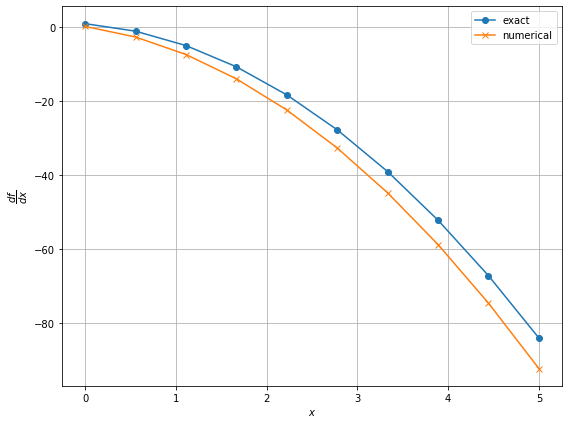

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(x_domain, df_dx_analytical, "o-", label='exact')
plt.plot(x_domain, df_dx_approx, "x-", label='numerical')
plt.grid(True)
plt.legend()

plt.xlabel(r"$x$")
plt.ylabel(r"$\dfrac{d f}{d x}$")

plt.tight_layout()
plt.show()

## Automatic step size

The only prior knowledge required is a record of function evaluations.

In [7]:
f_evaluations = f(x_domain)

A utility function to estimate a scaling factor:

In [8]:
def calculate_scaling_factor(sorted_evaluations):
    index_max = len(sorted_evaluations) - 1
    max_min_gap = 0.0
    while max_min_gap <= 0:
        if index_max < 0:
            raise RuntimeError("No valid max-min gap can be calculated.")
            
        max_min_gap = sorted_evaluations[index_max] - sorted_evaluations[0]
        index_max -= 1
    
    min_value = sorted_evaluations[0]
    scaling_factor = max_min_gap / min_value
    if scaling_factor > 1:
        scaling_factor = 1 / scaling_factor
    return scaling_factor

### Approach 1: step size relative to the norm of the absolute minimum value of the function

In [9]:
def dx_relative_evaluation_order(evaluations):
    evaluations_without_zeros = evaluations[np.abs(evaluations) > 0]
    evaluations_absolute_values = np.abs(evaluations_without_zeros)  # this is necessary for decreasing derivative cases
    evaluations_absolute_values_sorted = np.sort(evaluations_absolute_values)
    scaling_factor = calculate_scaling_factor(evaluations_absolute_values_sorted)
    return scaling_factor * np.linalg.norm(np.min(evaluations_absolute_values))

In [10]:
dx1 = dx_relative_evaluation_order(f_evaluations)

dx1

0.16716291149669313

**REMARK:**

This approach is not suitable when `x_final - x_initial < 1`. Solutions are under investigations! Suggestions are welcome!

### Approach 2: minimum difference among all function evaluations recorded

In [11]:
def dx_min_cut(evaluations, tol=1e-12):
    evaluations_without_zeros = evaluations[np.abs(evaluations) > 0]
    sorted_evaluations = np.sort(np.abs(evaluations_without_zeros))  # increasing order
    scaling_factor = calculate_scaling_factor(sorted_evaluations)
    
    dx = 0.0
    next_index = 1
    num_of_evaluations = len(sorted_evaluations)
    while dx < tol:
#         print(f"{num_of_evaluations}\t{next_index}\t{dx}\t{scaling_factor}")
        if next_index == num_of_evaluations:
            raise RuntimeError("No valid step can be calculated.")
            
        dx = scaling_factor * np.abs(sorted_evaluations[next_index] - sorted_evaluations[0])
        next_index += 1
        
    if dx < tol:
        raise RuntimeError("No significant step can be estimated.")
    
    return dx

In [12]:
dx2 = dx_min_cut(f_evaluations)

dx2

0.002560991680311449

## Comparing the results

In [13]:
df_dx_analytical = df_dx_exact(x_domain)
df_dx_approx1 = df_dx_numerical(f, x_domain, dx1)
df_dx_approx2 = df_dx_numerical(f, x_domain, dx2)

assert len(df_dx_analytical) == len(df_dx_approx1) == len(df_dx_approx2)

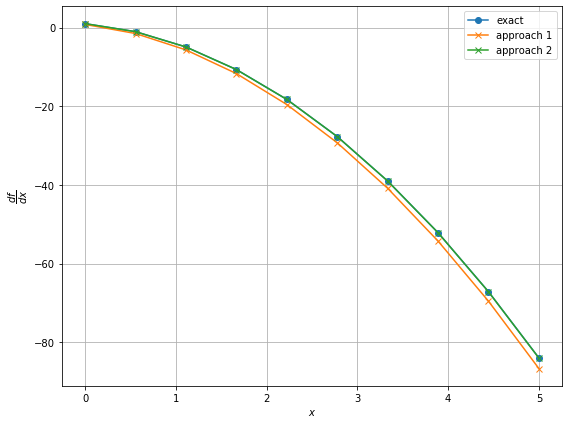

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(x_domain, df_dx_analytical, "o-", label='exact')
plt.plot(x_domain, df_dx_approx1, "x-", label='approach 1')
plt.plot(x_domain, df_dx_approx2, "x-", label='approach 2')
plt.grid(True)
plt.legend()

plt.xlabel(r"$x$")
plt.ylabel(r"$\dfrac{d f}{d x}$")

plt.tight_layout()
plt.show()